In [4]:
import paddle
import numpy as np 
from matplotlib import pyplot as plt

In [5]:
def make_multiclass_classification(n_samples=100, n_features=2, n_classes=3, shuffle=True, noise=0.1):
    n_samples_per_class = [int(n_samples / n_classes) for k in range(n_classes)]
    for i in range(n_samples - sum(n_samples_per_class)):
        n_samples_per_class[i % n_classes] +=1
    X = paddle.zeros([n_samples, n_features])
    y = paddle.zeros([n_samples], dtype='int32')
    centroids = paddle.randperm(2 ** n_features)[:n_classes] 
    centroids_bin = np.unpackbits(centroids.numpy().astype('uint8')).reshape((-1, 8))[:, -n_features:]
    centroids = paddle.to_tensor(centroids_bin, dtype='float32') 
    centroids = 1.5 * centroids -1 
    X[:, :n_features] = paddle.randn(shape=[n_samples, n_features])
    stop = 0
    for k, centroids in enumerate(centroids):
        start, stop = stop, stop + n_samples_per_class[k]
        y[start:stop] = k % n_classes
        X_k = X[start:stop, :n_features]
        A = 2 * paddle.rand(shape=[n_features, n_features]) - 1
        X_k[...] = paddle.matmul(X_k, A)
        X_k += centroids
        X[start:stop, :n_features] = X_k 
    if noise > 0.0:
        noise_mask = paddle.rand([n_samples]) < noise
        for i in range(len(noise_mask)):
            if noise_mask[i]:
                y[i] = paddle.randint(n_classes, shape=[1]).astype('int32')
    if shuffle:
        idx = paddle.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]
    return X, y

W0609 17:52:59.129487 42051 gpu_resources.cc:119] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 12.0, Runtime API Version: 11.8
W0609 17:52:59.130853 42051 gpu_resources.cc:164] device: 0, cuDNN Version: 8.9.


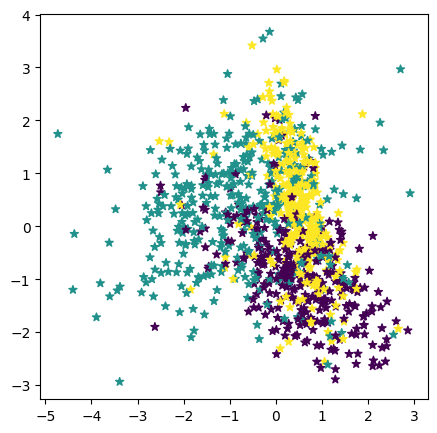

In [6]:
paddle.seed(3)

n_samples = 1000
X, y = make_multiclass_classification(n_samples=n_samples, n_features=2, n_classes=3, noise=0.2)

plt.figure(figsize=(5,5))
plt.scatter(x=X[:, 0].tolist(), y=X[:, 1].tolist(), marker='*', c=y.tolist())
plt.show()

In [7]:
num_train = 640
num_dev = 160
num_test = 200

X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train+num_dev], y[num_train:num_train+num_dev]
X_test, y_test = X[num_train+num_dev:], y[num_train+num_dev:]

print("X_train shape: ",X_train.shape,"y_train shape: ",y_train.shape)

X_train shape:  [640, 2] y_train shape:  [640]


In [8]:
print(y_train[:5])

Tensor(shape=[5], dtype=int32, place=Place(gpu:0), stop_gradient=True,
       [2, 0, 2, 0, 0])


In [9]:
def softmax(X):
    x_max = paddle.max(X, axis=1, keepdim=True)
    x_exp = paddle.exp(X - x_max)
    partition = paddle.sum(x_exp, axis=1, keepdim=True)
    return x_exp / partition
X = paddle.to_tensor([[0.1, 0.2, 0.3, 0.4]])
predict = softmax(X)
print(predict)

Tensor(shape=[1, 4], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.21383820, 0.23632778, 0.26118261, 0.28865141]])


In [10]:
# 基础算子模型
class Op(object):
    def __init__(self):
        pass

    def __call__(self, inputs):
        return self.forward(inputs)

    def forward(self, inputs):
        raise NotImplementedError

    def backward(self, inputs):
        raise NotImplementedError

In [11]:
class Model_SR(Op):
    def __init__(self, input_size, output_size):
        super(Model_SR, self).__init__()
        self.params = {}
        self.params['W'] = paddle.zeros(shape=[input_size, output_size])
        self.params['b'] = paddle.zeros(shape=[output_size])
        self.outputs = None

    def __call__(self, inputs):
        return self.forward(inputs)

    def forward(self, inputs):
        score = paddle.matmul(inputs, self.params['W']) + self.params['b']
        self.outputs = softmax(score)
        return self.outputs

In [12]:
inputs = paddle.randn(shape=[1, 4])
print("Input is: ",inputs)
model = Model_SR(input_size=4, output_size=3)
outputs = model(inputs)
print("Output is: ", outputs)

Input is:  Tensor(shape=[1, 4], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[-0.52676457,  0.91284317, -0.96104133,  0.51129621]])
Output is:  Tensor(shape=[1, 3], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.33333334, 0.33333334, 0.33333334]])


In [13]:
class MultiCrossEntropyLoss(Op):
    def __init__(self):
        self.predicts = None
        self.labels = None
        self.num = None 

    def __call__(self, predicts, labels):
        return self.forward(predicts, labels)

    def forward(self, predicts, labels):
        self.predicts = predicts 
        self.labels = labels
        self.num = self.predicts.shape[0]
        loss = 0
        for i in range(0, self.num):
            index = self.labels[i]
            loss -= paddle.log(self.predicts[i][index])
        return loss / self.num 

In [14]:
labels = paddle.to_tensor([0])
mcs_loss = MultiCrossEntropyLoss()
print(mcs_loss(outputs, labels))

Tensor(shape=[], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       1.09861219)


In [15]:
class Model_SR(Op):
    def __init__(self, input_size, output_size):
        super(Model_SR, self).__init__()
        self.params = {}
        self.params['W'] = paddle.zeros(shape=[input_size, output_size])
        self.params['b'] = paddle.zeros(shape=[output_size])
        self.grads = {}
        self.X = None
        self.outputs = None
        self.output_size = output_size

    def __call__(self, inputs):
        return self.forward(inputs)

    def forward(self, inputs):
        self.X = inputs
        score = paddle.matmul(inputs, self.params['W']) + self.params['b']
        self.outputs = softmax(score)
        return self.outputs

    def backward(self, labels):
        N = labels.shape[0]
        labels = paddle.nn.functional.one_hot(labels, self.output_size)
        self.grads['W'] = -1 / N * paddle.matmul(self.X.t(), (labels - self.outputs))
        self.grads['b'] = -1 / N * paddle.matmul(paddle.ones(shape=[N]), (labels-self.outputs))

In [16]:
class RunnerV2(object):
    def __init__(self, model, optimizer, metric, loss_fn):
        self.model = model
        self.optimizer = optimizer
        self.metric = metric
        self.loss_fn = loss_fn
        self.train_scores = []
        self.dev_scores = []
        self.train_loss = []
        self.dev_loss = []

    def train(self, train_set, dev_set, **kwargs):
        num_epochs = kwargs.get("num_epochs", 0)
        log_epochs = kwargs.get("log_epochs", 100)
        save_path = kwargs.get("save_path", "model_bast.pdparams")
        print_grads = kwargs.get("print_grads", None)
        best_score = 0
        for epoch in range(num_epochs):
            X, y = train_set
            logits =self.model(X)
            trn_loss = self.loss_fn(logits, y).item()
            self.train_loss.append(trn_loss)
            trn_score = self.metric(logits, y).item()
            self.train_scores.append(trn_score)
            self.model.backward(y)
            if print_grads is not None:
                print_grads(self.model) 
            self.optimizer.step()
            dev_score, dev_loss = self.evaluate(dev_set)
            if dev_score > best_score:
                self.save_model(save_path)
                print(f"best accuracy performance has been updated: {best_score:.5f} --> {dev_score:.5f}")
                best_score = dev_score
            if epoch % log_epochs == 0:
                print(f"[Train] epoch: {epoch}, loss: {trn_loss}, score: {trn_score}")
                print(f"[Dev] epoch: {epoch}, loss: {dev_loss}, score: {dev_score}")
    
    def evaluate(self, data_set):
        X, y = data_set
        logits = self.model(X)
        loss = self.loss_fn(logits, y).item()
        self.dev_loss.append(loss)
        score = self.metric(logits, y).item()
        self.dev_scores.append(score)
        return score, loss

    def predict(self, X):
        return self.model(X)

    def save_model(self, save_path):
        paddle.save(self.model.params, save_path)

    def load_model(self, save_path):
        self.model.params = paddle.load(save_path)

In [19]:
from abc import abstractmethod

class Optimizer(object):
    def __init__(self, init_lr, model):
        self.init_lr = init_lr
        self.model = model 

    @abstractmethod
    def step(self):
        pass

In [20]:
class SimpleBatchGD(Optimizer):
    def __init__(self, init_lr, model):
        super(SimpleBatchGD, self).__init__(init_lr, model)

    def step(self):
        if isinstance(self.model.params, dict):
            for key in self.model.params.keys():
                self.model.params[key] = self.model.params[key] - self.init_lr * self.model.grads[key]

In [22]:
def accuracy(preds, labels):
    if preds.shape[1] == 1:
        preds = paddle.cast((preds>=0.5), dtype='float32')
    else:
        preds = paddle.argmax(preds, axis=1, dtype='int32')
    return paddle.mean(paddle.cast(paddle.equal(preds, labels), dtype='float32'))

preds = paddle.to_tensor([[0.], [1.], [1.], [0.]])
labels = paddle.to_tensor([[1.], [1.], [0.], [0.]])
print("accuracy is: ", accuracy(preds, labels))

accuracy is:  Tensor(shape=[], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       0.50000000)


In [23]:
input_size = 2
output_size = 3
model = Model_SR(input_size, output_size)
optimizer = SimpleBatchGD(init_lr=0.1, model=model)
loss_fn = MultiCrossEntropyLoss()
metric = accuracy
runner = RunnerV2(model, optimizer, metric, loss_fn)
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=500, log_epochs=50, eval_epochs=1, save_path="./checkpoint/model_best.pdparams")

best accuracy performance has been updated: 0.00000 --> 0.61875
[Train] epoch: 0, loss: 1.098615050315857, score: 0.3500000238418579
[Dev] epoch: 0, loss: 1.0767663717269897, score: 0.6187499761581421
best accuracy performance has been updated: 0.61875 --> 0.63125
best accuracy performance has been updated: 0.63125 --> 0.63750
best accuracy performance has been updated: 0.63750 --> 0.64375
best accuracy performance has been updated: 0.64375 --> 0.65000
best accuracy performance has been updated: 0.65000 --> 0.65625
best accuracy performance has been updated: 0.65625 --> 0.66250
best accuracy performance has been updated: 0.66250 --> 0.66875
best accuracy performance has been updated: 0.66875 --> 0.67500
best accuracy performance has been updated: 0.67500 --> 0.68125
best accuracy performance has been updated: 0.68125 --> 0.68750
[Train] epoch: 50, loss: 0.843696117401123, score: 0.6546874642372131
[Dev] epoch: 50, loss: 0.8472301363945007, score: 0.6875
[Train] epoch: 100, loss: 0.8307

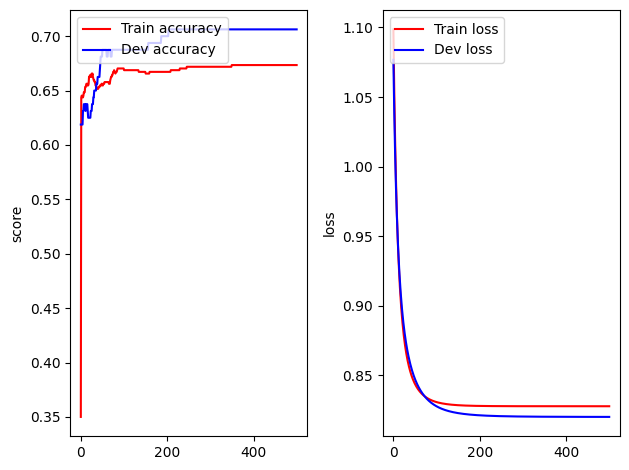

In [24]:
def plot(runner):
    plt.figure()
    plt.subplot(1,2,1)
    epochs = [i for i in range(len(runner.train_scores))]
    plt.plot(epochs, runner.train_scores, color="red", label="Train accuracy")
    plt.plot(epochs, runner.dev_scores, color="blue", label="Dev accuracy")
    plt.ylabel("score")
    plt.legend(loc="upper left")
    plt.subplot(1,2,2)
    plt.plot(epochs, runner.train_loss, color="red", label="Train loss")
    plt.plot(epochs, runner.dev_loss, color="blue", label="Dev loss")
    plt.ylabel("loss")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

plot(runner)

In [25]:
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.6200/0.8703


In [26]:
from sklearn.datasets import load_iris

def load_data(shuffle=True):
    X = np.array(load_iris().data, dtype=np.float32)
    y = np.array(load_iris().target, dtype=np.float32)

    X = paddle.to_tensor(X)
    y = paddle.to_tensor(y)

    X_min = paddle.min(X, axis=0)
    X_max = paddle.max(X, axis=0)
    X = (X-X_min) / (X_max-X_min)

    if shuffle:
        idx = paddle.randperm(X.shape[0])
        X = X[idx]
        y = y[idx]
    return X, y

In [34]:
paddle.seed(102)

num_train = 120
num_dev = 15
num_test = 15

X, y = load_data(shuffle=True)
y = paddle.cast(y, dtype='int32')
X_train, y_train = X[:num_train], y[:num_train]
X_dev, y_dev = X[num_train:num_train+num_dev], y[num_train:num_train+num_dev]
X_test, y_test = X[num_train+num_dev:], y[num_train+num_dev:]

print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)

X_train shape:  [120, 4] y_train shape:  [120]


In [28]:
print(X_train[:5])

Tensor(shape=[5, 4], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [[0.47222218, 0.41666666, 0.64406782, 0.70833325],
        [0.05555550, 0.12499998, 0.05084745, 0.08333334],
        [0.38888881, 0.74999994, 0.11864407, 0.08333334],
        [0.27777779, 0.70833331, 0.08474576, 0.04166666],
        [0.63888884, 0.37500003, 0.61016947, 0.49999994]])


In [35]:
print(y_train[:5])

Tensor(shape=[5], dtype=int32, place=Place(gpu:0), stop_gradient=True,
       [2, 0, 0, 0, 1])


In [31]:
input_size = 4
output_size = 3
model = Model_SR(input_size, output_size)

In [40]:
optimizer = SimpleBatchGD(init_lr = 0.2, model=model)
loss_fn = MultiCrossEntropyLoss()
metric = accuracy
runner = RunnerV2(model, optimizer, metric, loss_fn)
runner.train([X_train, y_train], [X_dev, y_dev], num_epochs=200, log_epochs=20, save_path="./checkpoint/model_best.pdparams")

best accuracy performance has been updated: 0.00000 --> 0.86667
[Train] epoch: 0, loss: 0.42119476199150085, score: 0.8750000596046448
[Dev] epoch: 0, loss: 0.45443105697631836, score: 0.8666667342185974
best accuracy performance has been updated: 0.86667 --> 0.93333
[Train] epoch: 20, loss: 0.4124046564102173, score: 0.8916667103767395
[Dev] epoch: 20, loss: 0.4449497163295746, score: 0.9333333969116211
[Train] epoch: 40, loss: 0.404254287481308, score: 0.9083333611488342
[Dev] epoch: 40, loss: 0.4361739754676819, score: 0.9333333969116211
[Train] epoch: 60, loss: 0.3966587781906128, score: 0.9166666865348816
[Dev] epoch: 60, loss: 0.42801403999328613, score: 0.9333333969116211
[Train] epoch: 80, loss: 0.3895486891269684, score: 0.9166666865348816
[Dev] epoch: 80, loss: 0.42039570212364197, score: 0.9333333969116211
[Train] epoch: 100, loss: 0.3828669786453247, score: 0.9166666865348816
[Dev] epoch: 100, loss: 0.4132574796676636, score: 0.9333333969116211
[Train] epoch: 120, loss: 0.3

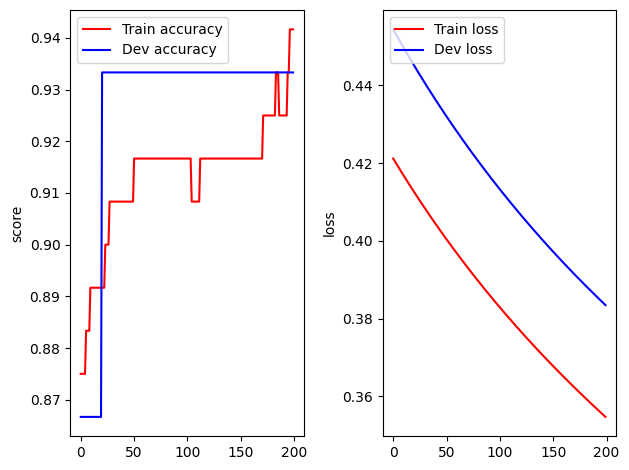

In [41]:
plot(runner)

In [42]:
score, loss = runner.evaluate([X_test, y_test])
print("[Test] score/loss: {:.4f}/{:.4f}".format(score, loss))

[Test] score/loss: 0.9333/0.4154


In [50]:
X, label = paddle.unsqueeze(X_test[0], axis=0), paddle.unsqueeze(y_test[0], axis=0)
predicts = runner.predict(X)
pred = paddle.argmax(predicts).numpy()
label = paddle.argmax(label).numpy()
print("The true category is {} and the predicted category is {}".format(label, pred))

The true category is 0 and the predicted category is 1
